# Project 8 - ML

In [1]:
#аугментации изображений
!pip install albumentations -q

In [2]:
!nvidia-smi

Sat Jun 26 08:45:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install --upgrade pip
!pip install -q tensorflow==2.3

     |████████████████████████████████| 1.5 MB 908 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ucx-py 0.16.0 requires pynvml, which is not installed.
stumpy 1.8.0 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
sklearn-pandas 2.1.0 requires scipy>=1.5.1, but you have scipy 1.4.1 which is incompatible.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.18.5 which is incompatible.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but y

In [4]:
import random
import numpy as np 
import pandas as pd 
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [13]:
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(2))
print('Размерность тестового датасета: ', test.shape)
display(test.head(2))
print('Размерность датасета c примером сабмишена: ', sample_submission.shape)
display(sample_submission.head(2))

Размерность тренировочного датасета:  (6682, 22)


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый


Размерность тестового датасета:  (1671, 21)


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый


Размерность датасета c примером сабмишена:  (1671, 2)


,sell_id,price
0,1099427284,0
1,1096405886,0


**train**        
22 признака
6682 записи
Тип int у 5 признаков: mileage, modelDate, numberOfDoors, productionDate, sell_id;           
тип float у целевой переменной: price;            
тип object у остальных 16 признаков.       
        
Признаки 'Руль' и 'ПТС' имеют 2 уникальных значения;               
'brand', 'Владельцы', 'Привод' - 3 уникальных значения;    
'fuelType', 'numberOfDoors', 'vehicleTransmission' - 4 уникальных значения.           
           
Много пропущенных значений у признака 'Владение' (4326 записей).                  
1 пропущенное значение у признака 'Владельцы'.             
                 
В test есть все признаки, кроме целевого 'price'.                
Признак 'Владение' в test имеет 1092 пропущенных значения.                 
                 

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [14]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [15]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == {row[1]}"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

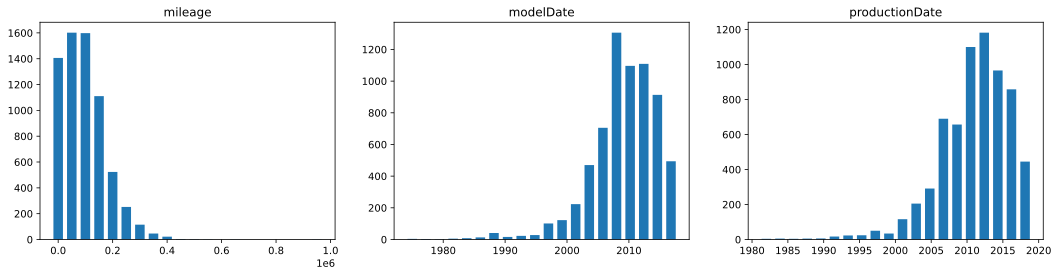

In [16]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

In [17]:
# Подгружаем ранее прошедший EDA датасет
data = pd.read_csv('../input/preproc-data/data.csv')

In [18]:
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Train,gearbox,drive4WD,защита_картера,мультифункциональный_руль,датчики_дождя_и_света,АБС,круиз_контроль,легкосплавные_диски,камера_заднего_вида,курсовая_устойчивость,color_code,Владельцы_code,engineDisplacement_log,enginePower_log,mileage_log,modelDate_log,productionDate_log,price_log
7399,внедорожник,BMW,белый,автодилер года победитель номинации организаци...,2.0,177,дизель,144437,2009,X1,5,0.0,2011,1099879366,автоматическая,2 владельца,1,полный,0,AT,1,0,0,0,0,0,0,0,0,1,3,1.098612,5.181784,11.880606,7.605890,7.606885,0.000000
4273,хэтчбек,BMW,чёрный,продаю бмв года выпуска реальным пробегом км о...,1.5,136,бензин,56094,2015,1ER,5,1495000.0,2017,1100201582,автоматическая,1 владелец,1,задний,1,AT,0,0,0,0,0,0,0,0,0,15,3,0.916291,4.919981,10.934802,7.608871,7.609862,14.217637
3362,внедорожник,MERCEDES,чёрный,автомобиль идеальном состоянии исправно работа...,2.0,211,бензин,133000,2012,GLK_KLASSE,5,1280000.0,2013,1099378480,автоматическая,2 владельца,1,полный,1,AT,1,0,0,0,0,0,0,0,0,15,3,1.098612,5.356586,11.798112,7.607381,7.607878,14.062371


In [19]:
df=data.copy()

# PreProc Tabular Data

In [20]:
# булевы признаки 
boolean_features = [
    'ПТС', 
    'drive4WD', 
    'защита_картера', 
    'мультифункциональный_руль', 
    'датчики_дождя_и_света', 
    'АБС', 
    'круиз_контроль', 
    'легкосплавные_диски', 
    'камера_заднего_вида', 
    'курсовая_устойчивость'
] 

# категориальные признаки
categorical_features = [
   # 'color_code', 
   # 'numberOfDoors', 
   # 'Владельцы_code'
]
cat_features_to_code = [
    'bodyType', 
    'brand', 
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод', 
    'gearbox', 
    'Владельцы', 
    'color'
]

# числовые признаки
numerical_features = [
   # 'engineDisplacement', 
   # 'enginePower', 
   # 'mileage', 
   # 'modelDate', 
   # 'productionDate', 
   # 'engineDisplacement_log', 
    'enginePower_log', 
    'mileage_log',
    'modelDate_log', 
    'productionDate_log'
]

In [21]:
lab_enc_col = cat_features_to_code + categorical_features
# Label Encoding
for column in lab_enc_col:
    df[column] = df[column].astype('category').cat.codes
        
# One-Hot Encoding: в pandas есть готовая функция - get_dummies.
df = pd.get_dummies(df, columns=lab_enc_col, dummy_na=False)

In [22]:
col_list = df.columns
new_bool_cols = col_list[28:]

In [23]:
new_bool_cols

Index(['bodyType_0', 'bodyType_1', 'bodyType_2', 'bodyType_3', 'bodyType_4',
       'bodyType_5', 'bodyType_6', 'bodyType_7', 'bodyType_8', 'bodyType_9',
       ...
       'color_6', 'color_7', 'color_8', 'color_9', 'color_10', 'color_11',
       'color_12', 'color_13', 'color_14', 'color_15'],
      dtype='object', length=142)

In [24]:
df.drop(['description','sell_id'], axis = 1, inplace=True)

In [25]:
# Теперь выделим тестовую часть
train_df = df.query('Train == 1').drop(['Train'], axis=1)
test_df = df.query('Train == 0').drop(['Train'], axis=1)

In [26]:
scaler = MinMaxScaler()
for column in numerical_features:
    scaler.fit(train_df[[column]])
    train_df[column] = scaler.transform(train_df[[column]])[:,0]
    test_df[column] = scaler.transform(test_df[[column]])[:,0]

In [27]:
# Запускаем и проверяем, что получилось
train_df.head(10)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,price,productionDate,ПТС,drive4WD,защита_картера,мультифункциональный_руль,датчики_дождя_и_света,АБС,круиз_контроль,легкосплавные_диски,камера_заднего_вида,курсовая_устойчивость,color_code,Владельцы_code,engineDisplacement_log,enginePower_log,mileage_log,modelDate_log,productionDate_log,price_log,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,brand_0,brand_1,brand_2,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,gearbox_0,gearbox_1,gearbox_2,gearbox_3,Владельцы_0,Владельцы_1,Владельцы_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15
0,3.0,272,245000,2007,4,599000.0,2007,1,1,0,0,0,0,0,0,0,0,15,3,1.386294,0.600140,0.892817,0.729450,0.660027,13.303019,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2.8,204,183000,2011,4,850000.0,2011,1,0,0,0,0,0,0,0,0,0,9,3,1.335001,0.465697,0.870582,0.819812,0.764868,13.652993,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3.5,306,122733,2009,4,1325000.0,2013,1,1,0,0,0,0,0,0,0,0,15,3,1.504077,0.655227,0.840140,0.774653,0.817210,14.096924,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2.0,180,151000,2011,4,815000.0,2011,1,0,0,0,0,0,0,0,0,0,1,3,1.098612,0.407260,0.855935,0.819812,0.764868,13.610945,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.8,160,140000,2007,5,810000.0,2011,1,0,0,0,0,0,0,0,0,0,1,3,1.029619,0.352306,0.850171,0.729450,0.764868,13.604791,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [28]:
cols = numerical_features + boolean_features
for col in new_bool_cols:
    cols.append(col)
len(cols)

156

## Split data

In [29]:
y = train_df.price.values     # наш таргет
X = train_df[cols]
X_sub = test_df[cols]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# Model 2: GradientBoostingRegressor

In [31]:
from sklearn import ensemble

In [32]:
params = {'n_estimators': 1000,
          'max_depth': 10,
          'max_features': 'sqrt',
          'min_samples_split': 4,
          'learning_rate': 0.01,
          'random_state': RANDOM_SEED,
          'verbose':1,
          'loss': 'lad'
         }

In [33]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1     1084922.6426            1.13m
         2     1077922.9800            2.13m
         3     1070342.2975            2.26m
         4     1062617.1970            2.43m
         5     1054958.7804            2.19m
         6     1047341.1017            2.03m
         7     1040484.2926            1.93m
         8     1033038.1523            1.88m
         9     1026699.7388            1.76m
        10     1019578.7286            1.73m
        20      956473.1943            1.54m
        30      898125.5401            1.47m
        40      842210.9271            1.43m
        50      793366.4832            1.42m
        60      749805.8089            1.38m
        70      709406.7260            1.39m
        80      669825.3078            1.43m
        90      636121.9281            1.41m
       100      606215.4511            1.38m
       200      407739.6097            1.19m
       300      311532.5706           59.19s
       40

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=10,
                          max_features='sqrt', min_samples_split=4,
                          n_estimators=1000, random_state=42, verbose=1)

In [34]:
GBreg = reg.predict(X_test)
print(f"TEST mape: {(mape(y_test, GBreg))*100:0.2f}%")

TEST mape: 11.98%


In [35]:
#for price
sub_predict_GBreg = reg.predict(X_sub)

sample_submission['price'] = sub_predict_GBreg
sample_submission.to_csv('GBreg_submission.csv', index=False)

# Model 3: CatBoostRegressor

In [36]:
model_cat = CatBoostRegressor(iterations = 15000,
                          #depth=10,
                          #learning_rate = 0.1,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=1000,
                          #task_type='GPU',
                         )
model_cat.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.01184
0:	learn: 0.9960091	test: 1.0204958	best: 1.0204958 (0)	total: 59.6ms	remaining: 14m 54s
500:	learn: 0.1893720	test: 0.1905356	best: 0.1905356 (500)	total: 1.78s	remaining: 51.5s
1000:	learn: 0.1633724	test: 0.1672174	best: 0.1672174 (1000)	total: 3.45s	remaining: 48.3s
1500:	learn: 0.1490365	test: 0.1542750	best: 0.1542750 (1500)	total: 5.11s	remaining: 46s
2000:	learn: 0.1392638	test: 0.1467801	best: 0.1467801 (2000)	total: 6.76s	remaining: 43.9s
2500:	learn: 0.1313405	test: 0.1411439	best: 0.1411439 (2500)	total: 8.43s	remaining: 42.1s
3000:	learn: 0.1250440	test: 0.1380458	best: 0.1380409 (2997)	total: 10.5s	remaining: 41.9s
3500:	learn: 0.1202013	test: 0.1356639	best: 0.1356636 (3498)	total: 12.7s	remaining: 41.6s
4000:	learn: 0.1160116	test: 0.1333199	best: 0.1333068 (3999)	total: 14.5s	remaining: 40s
4500:	learn: 0.1116243	test: 0.1317649	best: 0.1317542 (4491)	total: 16.2s	remaining: 37.7s
5000:	learn: 0.1085805	test: 0.1307157	best: 0.1307085 (4999

In [37]:
# for price
test_predict_catboost = model_cat.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.75%


### Submission

In [38]:
sub_predict_catboost = model_cat.predict(X_sub)

sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

## Simple Dense NN

In [39]:
# 11.84
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.7))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.7))
model.add(L.Dense(1, activation="linear"))

In [40]:
# # 11.95
# from tensorflow.keras import initializers
# initializer = tf.keras.initializers.VarianceScaling(
#     scale=1.0, mode="fan_in", distribution="truncated_normal", seed=RANDOM_SEED
# )

In [41]:
# model = Sequential()
# model.add(L.Dense(512, kernel_initializer=initializer, input_dim=X_train.shape[1], activation="relu"))
# #model.add(L.BatchNormalization(scale=False, center=False))
# model.add(L.Dense(256, kernel_initializer=initializer, activation="relu"))
# model.add(L.Dropout(0.2))
# model.add(L.Dense(1, activation="linear"))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               80384     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 211,969
Trainable params: 211,969
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compile model
optimizer = tf.keras.optimizers.Adam(lr=0.01, amsgrad=True)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [44]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau

In [45]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', 
                             monitor=['val_MAPE'], 
                             verbose=0, 
                             mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=100, 
                          restore_best_weights=True, 
                          verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                              factor=0.25,
#                              patience=10,
#                              min_lr=0.0000001,
#                              verbose=1,
#                              mode='auto')
callbacks_list = [checkpoint, earlystop]#, reduce_lr]

### Fit

In [46]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=2000, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

Restoring model weights from the end of the best epoch.
Epoch 01134: early stopping


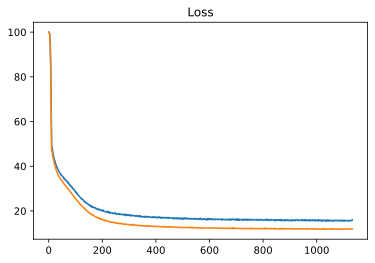

In [47]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [48]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [49]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.90%


In [50]:
sub_predict_nn1 = model.predict(X_sub)

sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP

In [51]:
# словарь замен частых выражений (создан на основе построенного выше облака слов)
dict_replace = {
    'авто':['автомобилей пробегом','авто','автомобили пробегом','машина','автомобили','автомобиль','машине'], 
    'состояние':['отличном состоянии','идеальном состоянии','хорошем состоянии','идеальном техническом состоянии'],
    'собственник':['продажа собственника', 'собственника', 'возможен торг', 'торг'],
    'дилер':['официального дилера','официальный дилер','двум документам','проверенных автомобилей','avilon автомобили'], 
    'кредит':['первоначальный взнос','условия кредитования','срок кредита','размер процентной ставки', 
              'срока кредита','оформлении кредита','сниженной ставки'],
    'сайт':['сайте rolfprobeg'],
    'приложение':['мобильном приложении'],
    'колесо':['давления шинах','литые легкосплавные диски','литые легкосплавные','легкосплавные диски','зимняя резина','комплекте зимние колёса','датчик давления','полный комплект'],
    'блок':['антиблокировочная система'],
    'обивка':['обивка салона','кожаная обивка'],
    'ключи':['комплекта ключей','комплект ключей'],
    'сиденье':['передних сидений','подогрев сидений','зонный подогрев','электрорегулировка сиденья'],
    'часто':['каждый день'],
    'зеркало':['обогрев зеркал', 'электропривод зеркал'],
    'книжка':['сервисная книжка'],
    'гарантия':['гарантия юридической чистоты','любые проверки','гарантию юридической чистоты','юридическую проверку'],
    'устойчивость':['система система курсовой устойчивости','антипробуксовочная система','навигационная система','система стартстоп'],
    'датчик':['датчик дождя','датчик света'],
    'камера':['камера заднего вида'],
    'партроник':['парктроник передний'],
    'фары':['светодиодные фары','фары противотуманные','омыватель фар','противотуманные фары'],
    'крепление':['система крепления'],
    'климатконтроль':['климатконтроль зонный'],
    'подушки':['подушки безопасности'],
    'сертифицирован':['inchcape certified'],
    'isofix':['isofix latch','крепления детских автокресел isofix'],
    'паспорт':['птс оригинал'],
    'руль':['рулевое колесо','регулировка руля','усилитель руля','кожаный руль','подогрев руля'],
    'компьютер':['бортовой компьютер'],
    'стеклоподъемник':['электростеклоподъемники передние'],
    'обслуживание':['комплексную диагностику','своевременное обслуживание','предпродажная подготовка'],
    'замок':['центральный замок','иммобилайзер центральный'],
    'багажник':['крышки багажника'],
    'запуск':['запуск двигателя'],
    'bmv':['bmw mini'],
    'крыша':['панорамная крыша'],
    'продажа':['причина продажи'],
    'выкуп':['срочный выкуп'],
    'диски':['тормозных дисков']
            }

In [52]:
data.description.fillna('автомобиль', inplace=True)

In [53]:
for elem in dict_replace:
    for word in dict_replace[elem]:
        data['description'] = data['description'].apply(lambda x: x.replace(word, elem))

In [54]:
# Для аугментации текста использовался обратный перевод (русский-английский-русский)
# Однако увеличение количества данных за счет аугментированных текстовых не дало прироста и значительно увеличило время обработки кода

In [55]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [56]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [57]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.19 s, sys: 5.79 ms, total: 1.2 s
Wall time: 1.2 s


In [58]:
tokenize.word_index

{'авто': 1,
 'система': 2,
 'автомобиля': 3,
 'состояние': 4,
 'кредит': 5,
 'руль': 6,
 'дилер': 7,
 'салон': 8,
 'гарантия': 9,
 'пакет': 10,
 'обслуживание': 11,
 'сиденье': 12,
 'фары': 13,
 'комплектация': 14,
 'года': 15,
 'bmw': 16,
 'колесо': 17,
 'водителя': 18,
 'собственник': 19,
 'пробег': 20,
 'км': 21,
 'лет': 22,
 'пассажира': 23,
 'датчик': 24,
 'комплект': 25,
 'подушки': 26,
 'птс': 27,
 'дтп': 28,
 'сиденья': 29,
 'диски': 30,
 'зеркало': 31,
 'пробегом': 32,
 'amg': 33,
 'передние': 34,
 'салона': 35,
 'сидений': 36,
 'задние': 37,
 'задний': 38,
 'владелец': 39,
 'покупке': 40,
 'обмен': 41,
 'полностью': 42,
 'обмене': 43,
 'замена': 44,
 'задних': 45,
 'продаю': 46,
 'условия': 47,
 'паспорт': 48,
 'устойчивость': 49,
 'год': 50,
 'mercedesbenz': 51,
 'продажа': 52,
 'цвет': 53,
 'масло': 54,
 'заднего': 55,
 'безопасности': 56,
 'дверей': 57,
 'обогрев': 58,
 'двигатель': 59,
 'защита': 60,
 'каско': 61,
 'части': 62,
 'состоянии': 63,
 'климатконтроль': 64,
 'к

In [59]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.15 s, sys: 2.64 ms, total: 1.15 s
Wall time: 1.15 s


In [60]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

авто проверен пунктам автокредит специальной ставке ауди центр север дилер audi входящий группу компаний являющийся одним крупнейших дилеров европе предлагает ряд услуг покупке продаже авто протяжении многих лет наш дилерский центр является лидером продаже авто среди дилеров audi россии предоставляет клиентам самый большой выбор авто audi других марок каждый авто проходит тщательную диагностику подготовку гарантировано находится состояние убедиться правильном выборе возможность пройти тестдрайв ― ознакомительную поездку интересующем автомобиле сможете ознакомиться автомобилем выходя дома наш менеджер проведет online презентацию видеозвонке покажет выбранный авто ауди центр север представляет уникальное предложение кредитованию авто индивидуальных условиях специалисты компании подберут лучшие кредит проверенных авто гарантией лет ждут сайт приложение
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  

### RNN NLP

In [61]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.7))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.7))

In [62]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))

model_nlp.add(L.LSTM(128, return_sequences=True))
model_nlp.add(L.Dropout(0.25))

model_nlp.add(L.LSTM(64))
model_nlp.add(L.Dropout(0.25))

model_nlp.add(L.Dense(32, activation="relu"))
model_nlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [63]:
combinedInput = L.concatenate([model_mlp.output, model_nlp.output])
# being our regression head
#head = L.Dense(256, kernel_initializer=initializer, activation="relu")(combinedInput)
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1, activation="linear")(head)

model_mlp_nlp = Model(inputs=[model_mlp.input, model_nlp.input], outputs=head)

In [64]:
model_mlp_nlp.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     9405440     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 128)     197120      embedding[0][0]                  
__________________________________________________________________________________________________
dense_3_input (InputLayer)      [(None, 156)]        0                                            
_______________________________________________________________________________________

### Fit

In [65]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_mlp_nlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [66]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', 
                             monitor=['val_MAPE'], 
                             verbose=0, 
                             mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', 
                          patience=10, 
                          restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [67]:
history = model_mlp_nlp.fit([X_train, text_train_sequences], y_train,
                    batch_size=256,
                    epochs=200, 
                    validation_data=([X_test, text_test_sequences], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/200
23/23 [==============================] - 74s 3s/step - loss: 99.3647 - MAPE: 99.3647 - val_loss: 94.2670 - val_MAPE: 94.2670
Epoch 2/200
23/23 [==============================] - 72s 3s/step - loss: 66.6510 - MAPE: 66.6510 - val_loss: 46.3500 - val_MAPE: 46.3500
Epoch 3/200
23/23 [==============================] - 72s 3s/step - loss: 46.8432 - MAPE: 46.8432 - val_loss: 41.5936 - val_MAPE: 41.5936
Epoch 4/200
23/23 [==============================] - 72s 3s/step - loss: 43.0096 - MAPE: 43.0096 - val_loss: 38.7201 - val_MAPE: 38.7201
Epoch 5/200
23/23 [==============================] - 72s 3s/step - loss: 41.2616 - MAPE: 41.2616 - val_loss: 36.4778 - val_MAPE: 36.4778
Epoch 6/200
23/23 [==============================] - 73s 3s/step - loss: 39.7062 - MAPE: 39.7062 - val_loss: 35.4760 - val_MAPE: 35.4760
Epoch 7/200
23/23 [==============================] - 72s 3s/step - loss: 38.1541 - MAPE: 38.1541 - val_loss: 34.1154 - val_MAPE: 34.1154
Epoch 8/200
23/23 [======================

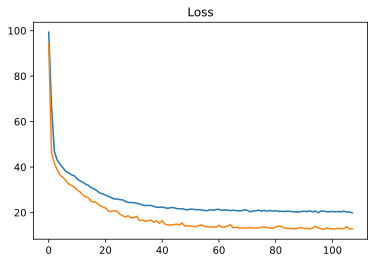

In [68]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [69]:
model_mlp_nlp.load_weights('../working/best_model.hdf5')
model_mlp_nlp.save('../working/nn_mlp_nlp.hdf5')

In [70]:
test_predict_nlp_ml = model_mlp_nlp.predict([X_test, text_test_sequences])
print(f"TEST mape: {(mape(y_test, test_predict_nlp_ml[:,0]))*100:0.2f}%")

TEST mape: 12.84%


In [71]:
sub_predict_nlp_ml = model_mlp_nlp.predict([X_sub, text_sub_sequences])
sample_submission['price'] = sub_predict_nlp_ml[:,0]
sample_submission.to_csv('nlp_ml_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

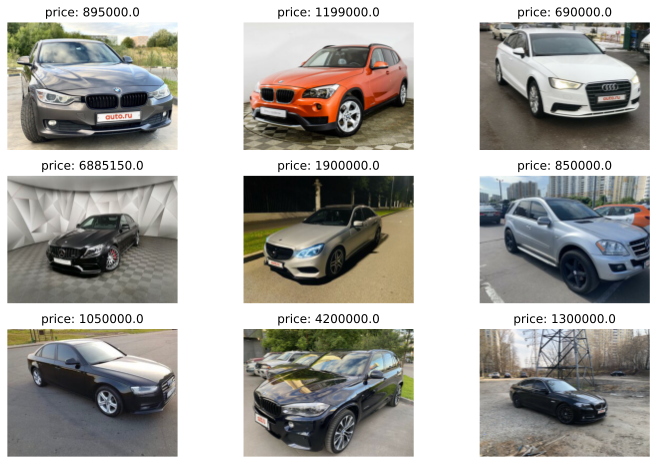

In [72]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [73]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

In [74]:
import albumentations

#Аугментация
augmentation = albumentations.Compose([
    #Размытие изображения
    albumentations.GaussianBlur(p=0.5),
    #Добавление шума
    albumentations.GaussNoise(p=0.5),
    #Поворот вокруг вертикальной оси
    albumentations.HorizontalFlip(p=0.5),
    #Изменение яркости
    albumentations.RandomBrightness(p=0.5,limit=(0.1,0.3)),
    #Изменение контраста
    albumentations.RandomContrast(p=0.5,limit=(0.1,0.3)),
    #Вращение изображения
    albumentations.ShiftScaleRotate(shift_limit=0.0625,      #Коэффициент изменения сдвига
                         scale_limit=(0.1,0.2),   #Коэффициент изменения масштаба
                         interpolation=1,         #Флаг для вида интерполяции (линейная)
                         border_mode=4,           #Флаг для экстраполяции (отражение)
                         rotate_limit=20,         #Угол поворота
                         p=0.7),                  #Вероятность
])

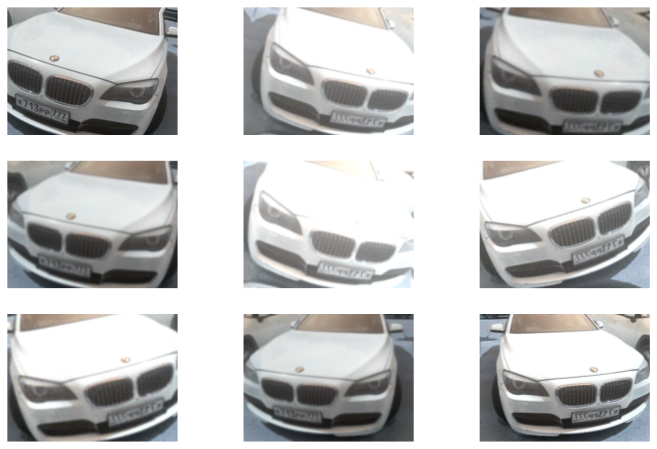

In [75]:
#пример аугментации
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [76]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, text, table_data, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, text, table_data), price

def tf_process_val_dataset_element(image, text, table_data, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, text, table_data), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, data.description.iloc[X_train.index], X_train, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, data.description.iloc[X_test.index], X_test, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, data.description.iloc[X_sub.index], X_sub, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [77]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3)
)

model_img = Sequential()
model_img.add(efficientnet_model)
model_img.add(L.GlobalAveragePooling2D())

43941888/43941136 [==============================] - 2s 0us/step


In [78]:
#строим нейросеть для анализа табличных данных
mlp_model = Sequential([
    L.Input(shape = X_train.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.7),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.7)
    ])

In [79]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(128, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(32, activation="relu"),
    L.Dropout(0.5)
    ])

In [80]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([model_img.output, nlp_model.output, mlp_model.output])

# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model_img_nlp_mlp = Model(inputs=[model_img.input, nlp_model.input, mlp_model.input], outputs=head)
model_img_nlp_mlp.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 256)     9405440     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256, 128)     197120      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 128)     0           lstm_2[0][0]                     
_______________________________________________________________________________________

In [81]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)
earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=4, 
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

## Finetune

Блок закомментирован в целях экономии вычислительного ресурса.
FineTuning не дал значительного прироста.

In [82]:
# optimizer = tf.keras.optimizers.Adam(0.005)

In [83]:
# #Заморозка весов
# model_img.trainable = False
# #Компиляция
# model_img_nlp_mlp.compile(
#     loss='MAPE', 
#     optimizer=optimizer, 
#     metrics='MAPE'
# )
# #Обучение
# history = model_img_nlp_mlp.fit(
#     train_dataset.batch(16),
#     epochs=10,
#     validation_data=test_dataset.batch(16),
#     callbacks=callbacks_list,
#     verbose=1
# )

# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

# test_predict_ft_0 = model_img_nlp_mlp.predict(test_dataset.batch(16))
# print(f"TEST mape: {(mape(y_test, test_predict_ft_0[:,0]))*100:0.2f}%")

# model_img_nlp_mlp.load_weights('../working/best_model.hdf5')
# model_img_nlp_mlp.save('../working/model_img_nlp_mlp.hdf5')

### Разморозка 40%

In [84]:
# optimizer = tf.keras.optimizers.Adam(0.0005)

In [85]:
# model_img.trainable = True
# #Количество слоев
# n_layer = len(model_img.layers)
# #Количество слоев для заморозки
# fine_tune_layer = int(n_layer * 0.6)
# #Заморозка
# for layer in model_img.layers[:fine_tune_layer]:
#     layer.trainable = False
# #Компиляция
# model_img_nlp_mlp.compile(
#     loss='MAPE', 
#     optimizer=optimizer, 
#     metrics='MAPE'
# )
# #Обучение
# history = model_img_nlp_mlp.fit(
#     train_dataset.batch(16),
#     epochs=10,
#     validation_data=test_dataset.batch(16),
#     callbacks=callbacks_list,
#     verbose=1
# )

# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

# test_predict_ft_40 = model_img_nlp_mlp.predict(test_dataset.batch(16))
# print(f"TEST mape: {(mape(y_test, test_predict_ft_40[:,0]))*100:0.2f}%")

# model_img_nlp_mlp.load_weights('../working/best_model.hdf5')
# model_img_nlp_mlp.save('../working/model_img_nlp_mlp.hdf5')

### Разморозка

In [86]:
# optimizer = tf.keras.optimizers.Adam(0.00005)

In [87]:
# model_img.trainable = True
# #Компиляция
# model_img_nlp_mlp.compile(
#     loss='MAPE', 
#     optimizer=optimizer, 
#     metrics='MAPE'
# )
# #Обучение
# history = model_img_nlp_mlp.fit(
#     train_dataset.batch(16),
#     epochs=10,
#     validation_data=test_dataset.batch(16),
#     callbacks=callbacks_list,
#     verbose=1
# )

# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

# test_predict_ft_100 = model_img_nlp_mlp.predict(test_dataset.batch(16))
# print(f"TEST mape: {(mape(y_test, test_predict_ft_100[:,0]))*100:0.2f}%")

# model_img_nlp_mlp.load_weights('../working/best_model.hdf5')
# model_img_nlp_mlp.save('../working/model_img_nlp_mlp.hdf5')

In [88]:
# finetune_sub_predict = model_img_nlp_mlp.predict(test_dataset.batch(16))
# sample_submission['price'] = finetune_sub_predict[:,0]
# sample_submission.to_csv('finetune_sub_predict.csv', index=False)

# Model Bonus: проброс признака

Пробросим 5 значимых признаков модели GradientBoostingRegression

productionDate_log    0.171003
mileage_log           0.149065
modelDate_log         0.140746
enginePower_log       0.114844
Владельцы_2           0.028488
dtype: float64

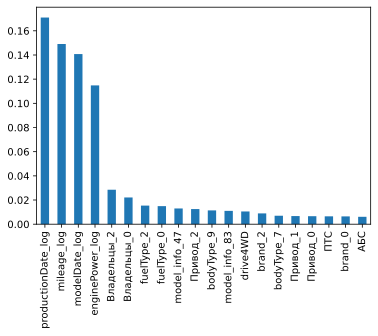

In [89]:
#Значимость параметров в модели CatBoostRegressor
imnortant_feature = pd.Series(reg.feature_importances_,index=X_train.columns).sort_values(ascending=False)
imnortant_feature.iloc[:20].plot(kind='bar')
#Выбор количества признаков
n = 5
#Вывод признаков
imnortant_feature.iloc[:n]

In [90]:
# Архитектура нейроннной сети
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.7))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.7))

In [91]:
# Архитектура сети с признаками
model_imp_feat = Sequential()
#Первый слой
model_imp_feat.add(L.Input(shape=[n]))

In [92]:
# Объединение
combinedInput = L.concatenate([model_mlp.output,model_imp_feat.output])

# head = L.Dense(128, activation='relu')(combinedInput)
# head = L.Dropout(0.35)(head)

head = L.Dense(64, activation='relu')(combinedInput)
head = L.Dropout(0.5)(head)

head = L.Dense(1, activation='linear')(head)
model_mlp_imp_feat = Model(inputs=[model_mlp.input,model_imp_feat.input],outputs=head)

model_mlp_imp_feat.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 156)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          80384       dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 256)          131328      dropout_13[0][0]                 
_______________________________________________________________________________________

In [93]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_mlp_imp_feat.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [94]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', 
    monitor=['val_MAPE'], 
    verbose=0, 
    mode='min'
)
earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

In [95]:
history = model_mlp_imp_feat.fit([X_train, X_train[imnortant_feature.iloc[:n].index]], y_train,
                    batch_size=1024,
                    epochs=1000, 
                    validation_data=([X_test, X_test[imnortant_feature.iloc[:n].index]], y_test),
                    callbacks=callbacks_list, 
                    verbose=1
                   )

Epoch 1/1000
6/6 [==============================] - 0s 73ms/step - loss: 99.9995 - MAPE: 99.9995 - val_loss: 99.9958 - val_MAPE: 99.9958
Epoch 2/1000
6/6 [==============================] - 0s 41ms/step - loss: 99.9724 - MAPE: 99.9724 - val_loss: 99.8677 - val_MAPE: 99.8677
Epoch 3/1000
6/6 [==============================] - 0s 38ms/step - loss: 99.6120 - MAPE: 99.6120 - val_loss: 98.7862 - val_MAPE: 98.7862
Epoch 4/1000
6/6 [==============================] - 0s 39ms/step - loss: 97.4634 - MAPE: 97.4634 - val_loss: 93.8748 - val_MAPE: 93.8748
Epoch 5/1000
6/6 [==============================] - 0s 39ms/step - loss: 89.3114 - MAPE: 89.3114 - val_loss: 77.8149 - val_MAPE: 77.8149
Epoch 6/1000
6/6 [==============================] - 0s 38ms/step - loss: 66.9650 - MAPE: 66.9650 - val_loss: 48.6492 - val_MAPE: 48.6492
Epoch 7/1000
6/6 [==============================] - 0s 38ms/step - loss: 51.6475 - MAPE: 51.6475 - val_loss: 52.8490 - val_MAPE: 52.8490
Epoch 8/1000
6/6 [=======================

In [96]:
model_mlp_imp_feat.load_weights('../working/best_model.hdf5')

test_predict_feat_bonus = model_mlp_imp_feat.predict([X_test, X_test[imnortant_feature.iloc[:n].index]])

print(f"TEST mape: {(mape(y_test, test_predict_feat_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.02%


In [97]:
feat_sub_predict = model_mlp_imp_feat.predict([X_sub, X_sub[imnortant_feature.iloc[:n].index]])
sample_submission['price'] = feat_sub_predict[:,0]
sample_submission.to_csv('feat_sub_predict.csv', index=False)

# Blend

### GradientBoostingRegression + MLP + CatBoost

Сделаем предсказания цены с помощью линейной регрессии

In [98]:
#Составляем DF результатов
df_sub_0 = pd.DataFrame(
    {'y_true':y_test,
     'y_pred_1':reg.predict(X_test), # GradientBoostingRegressor
     'y_pred_2':model.predict(X_test).flatten(),  # simple neural network
     #'y_pred_3':model_cat.predict(X_test),    
     #'y_pred_4':model_mlp_nlp.predict([X_test, text_test_sequences]).flatten(),
     #'y_pred_5':model_mlp_imp_feat.predict([X_test, X_test[imnortant_feature.iloc[:n].index]]).flatten()
})
df_sub_1 = pd.DataFrame(
    {'y_true':0,
     'y_pred_1':reg.predict(X_sub),
     'y_pred_2':model.predict(X_sub).flatten(),
     #'y_pred_3':model_cat.predict(X_sub),
     #'y_pred_4':model_mlp_nlp.predict([X_sub, text_sub_sequences]).flatten(),
     #'y_pred_5':model_mlp_imp_feat.predict([X_sub, X_sub[imnortant_feature.iloc[:n].index]]).flatten()
})

df_sub_0['Train'] = 0
df_sub_1['Train'] = 1
df_sub = pd.concat([df_sub_0,df_sub_1])
df_sub.dropna(axis=0, inplace=True)

In [99]:
df_sub

,y_true,y_pred_1,y_pred_2,Train
0,539000.0,6.175874e+05,6.008640e+05,0
1,950000.0,9.795879e+05,8.623472e+05,0
2,1050000.0,1.215319e+06,1.237903e+06,0
3,460000.0,4.770802e+05,4.606768e+05,0
4,1261000.0,1.288323e+06,1.339256e+06,0
...,...,...,...,...
1666,0.0,1.110949e+06,9.425821e+05,1
1667,0.0,2.556646e+06,2.955316e+06,1
1668,0.0,1.670065e+06,1.624101e+06,1
1669,0.0,1.063733e+06,1.042966e+06,1


In [100]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [101]:
model_meta = LinearRegression(n_jobs=-1)
model_meta.fit(df_sub.query('Train==0').iloc[:,1:],df_sub.query('Train==0').iloc[:,0])
df_sub['y_pred'] = model_meta.predict(df_sub.iloc[:,1:])

<AxesSubplot:xlabel='y_pred', ylabel='Count'>

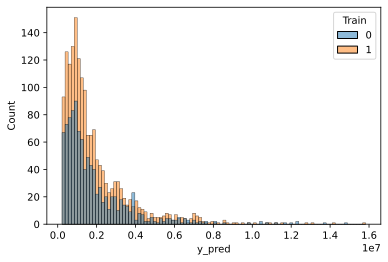

In [102]:
#Гистограмма целевого признака
sns.histplot(data=df_sub,x='y_pred',hue='Train',bins=100)

In [103]:
print(f"TEST mape: {mape(df_sub.query('Train==0')['y_true'],df_sub.query('Train==0')['y_pred'])*100:0.2f}%")

TEST mape: 13.51%


In [104]:
sample_submission['price'] = df_sub.query('Train==0')['y_pred']
sample_submission.to_csv('blend_lr_submission.csv', index=False)

Простой блендинг трех моделей

In [105]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]+ GBreg) / 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.03%


In [106]:
simple_blend_3_predict = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_GBreg) / 3
sample_submission['price'] = simple_blend_3_predict
sample_submission.to_csv('simple_blend_3_predict.csv', index=False)

### CatBoost

In [107]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.28%


In [108]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

## GBreg Blend

In [109]:
GBR_blend_predict = (GBreg + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, GBR_blend_predict))*100:0.2f}%")

TEST mape: 11.04%


In [110]:
blend_sub_predict = (sub_predict_GBreg + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('GBR_blend.csv', index=False)

# Выводы       

***В ходе выполнения проекта:***       

- EDA (датасет очищен,сгенерированы новые признаки, выполнены нормализация и стандартизация числовых признаков, применены методы для кодирования категориальных признаков);
- подобрана нейронная сеть по обработке табличных данных;
- обработан текстовый признак (построено облако слов, выявлены новые признаки на основе значимых ловосочетаний, применены дополнительные методы предобработки текста - лемматизация, была попытка увеличения текстовых данных за счет аугментированного путем обратного перевода текста, однако это значительно увеличило время расчетов и потребляемый ресурс и не дало прироста);
- построена модель по обработке естественного языка (NLP), объединенная в Multi-Input с нейронной сетью для анализа и табличных данных;
- подобраны методы аугментации изображений для сохранения первоначального цвета автомобиля;
- построена модель для обработки изображений, объединенная в Multi-Input с нейронной сетью для анализа табличных данных и текста (использован EfficientNetB3, применены transfer learning и finetuning, которые, к сожалению, не дали прироста);
- применён метод проброса критерия, но прироста это не дало;
- на основе предсказаний моделей, подобраны веса с помощью мета-модели (LinearRegression) для ансамблирования моделей;
- простой блендинг градиентного бустинга и нейронной сети дал лучший результат.        
               
               
***Score на Kaggle 11.47***               
21 место в соревновании               

***Возможные пути для улучшения работы***                     
                              
1. Очистить от выбросов числовые признаки;
2. Сгенерировать дополнительные признаки более детальнее рассмотрев комбинации признаков и что они могут дать;
3. Поэкспериментировать с различными моделями и их ансамблированием;
4. Подобрать пути улучшения скора с использованием картинок более детально (другие предобученные модели, датасеты, разные схемы разморозки весов при finetuning и тд).
